# SPS Python Tutorial, Day 1
---
*January 29/30, 2020*

Luc Le Pottier, University of Michigan

## **3: visualization**
Now we cover some of the most useful data visualization and plotting utilities through a series of examples.

we can summarize the basic utility of a few of the most useful plotting libraries as so:
- **`matplotlib`** module:
    - provides a baseline interface for all plotting
    - very customizable
    - can be annoying to get everything *just right*
    - scripts might be long
- **`seaborn`** wrapper module for `matplotlib`:
    - very intuitive
    - works with `pandas` quite nicely
    - automatically finds pretty formatting options
    - more confusing to customize than `matplotlib`
- **`pandas`** plotting functions within the `DataFrame` object
    - data 
    - slow
- **`corner`** module and other custom plot modules
    - provide quick implementations of hard-to-write functions; in this case, corner plots
    - huge positive side to the open-source nature of python 
    
    
This next part of the tutorial will provide examples of advanced plotting capabilities for each utility. We will also bring various scientific computing libraries into the fold, i.e. `scipy`, `sklearn`, and more. 

This is done in the hopes of sharpening our understanding of data preprocessing and analysis, which **is** the most important part of machine learning. 

### 3.1: custom distributions

We can create custom probability distribution functions and sample from them using the `scipy` module. 

This is helpful in 
- monte carlo simulations
- sample generation for training data
- sample augmentation for training data

We'll generate the blackbody radiation pdf
$\frac{x^3}{e^{x} - 1}$

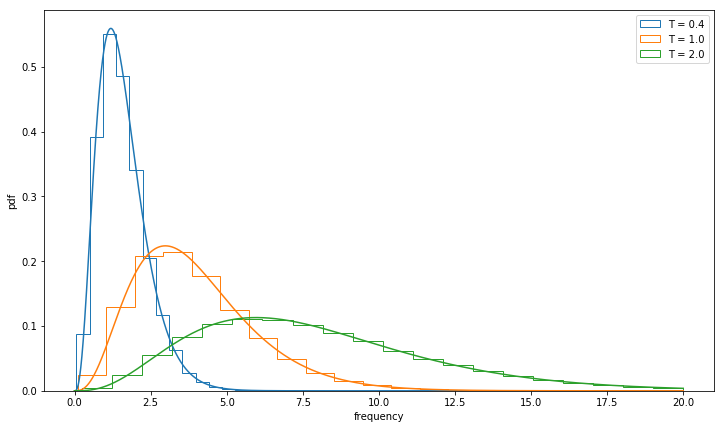

In [189]:
import scipy.stats 
import scipy.interpolate
import scipy.integrate 
import numpy as np
import matplotlib.pyplot as plt

# custom distributions
x = np.linspace(0.0, 20, int(1e4))

T_array = [0.4, 1.0, 2.0]

# custom distribution function
def p(v, T):
    return (v**3)/(np.exp(x/T) - 0.1)

# function to approximate pdf and cdf
def pdf_and_cdf(p, x, *args, **kwargs):
    
    # integrate function to get norm constant
    norm_constant = scipy.integrate.simps(p(x, *args, **kwargs), x)
    
    # calculate pdf and cdp for x values
    pdf = p(x, *args, **kwargs)/norm_constant
    cdf = np.cumsum(pdf)
    cdf /= max(cdf)
    
    return pdf, cdf

# generate samples from a cdf
def generate_samples(n, cdf, x):
    intf = scipy.interpolate.interp1d(cdf, x)
    u = np.random.uniform(intf.x.min(), intf.x.max(), int(n))
    return intf(u)

plt.figure(figsize=(12,7))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i,T in enumerate(T_array):
    pdf, cdf = pdf_and_cdf(p, x, T)
    plt.hist(generate_samples(100000, cdf, x), bins=20, density=1, histtype='step', label='T = {}'.format(T), color=colors[i])
    plt.plot(x, pdf, color=colors[i])

plt.xlabel('frequency')
plt.ylabel('pdf')
plt.legend()
plt.show()


### 3.2 resampling from existing distributions

We can also draw from existing histograms, effectively re-sampling. First we grab the `iris` dataset, which we will use later, and make a histogram of the sepal_width variable, using the pandas interface:

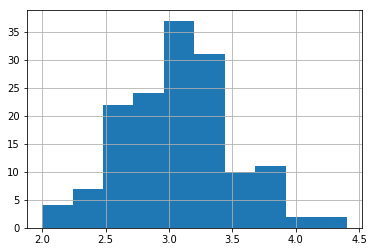

In [190]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# pandas dataframe type
iris = sns.load_dataset('iris')

iris.sepal_width.hist(bins=10)
plt.show()

This looks good, but lets augment it! We can generate a rough pdf using the bins and edges of the histogram:

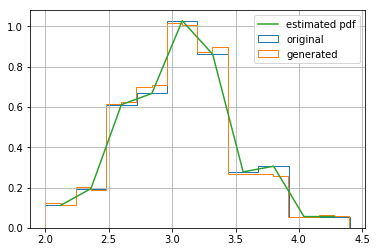

In [192]:
bins, xpdf = np.histogram(iris.sepal_width, bins=10, density=1)
xplot = edges[:-1] + np.diff(edges)/2
pdf = np.asarray([0,] + list(bins))


cdf = np.cumsum(pdf)
cdf /= max(cdf)

def generate_samples(n, cdf, x):
    intf = scipy.interpolate.interp1d(cdf, x)
    u = np.random.uniform(intf.x.min(), intf.x.max(), int(n))
    return intf(u)

iris.sepal_width.hist(bins=10, density=1, histtype='step', label='original')
plt.hist(generate_samples(5000, cdf, xpdf), bins=20, density=1, histtype='step', label='generated')
plt.plot(xplot, bins, label='estimated pdf')
plt.xticks(np.arange(2, 5, 0.5), np.arange(2, 5, 0.5))
plt.legend()
plt.show()

### 3.3 pair and corner plots

These plots are good for visualizing high-dimensional datasets, in particle physics and other fields.

Image a situation where you have individual samples, characterized by some mid-dimensional set of observables, such as the iris dataset. Corner/pair plots will show you the distributions and co-distributions of each variable, and each combination of variables, respectively. 

First, seaborn: this provides a very readable visualization of the data, indicating differences in distributions between species and characteristics.

/home/luclepot/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


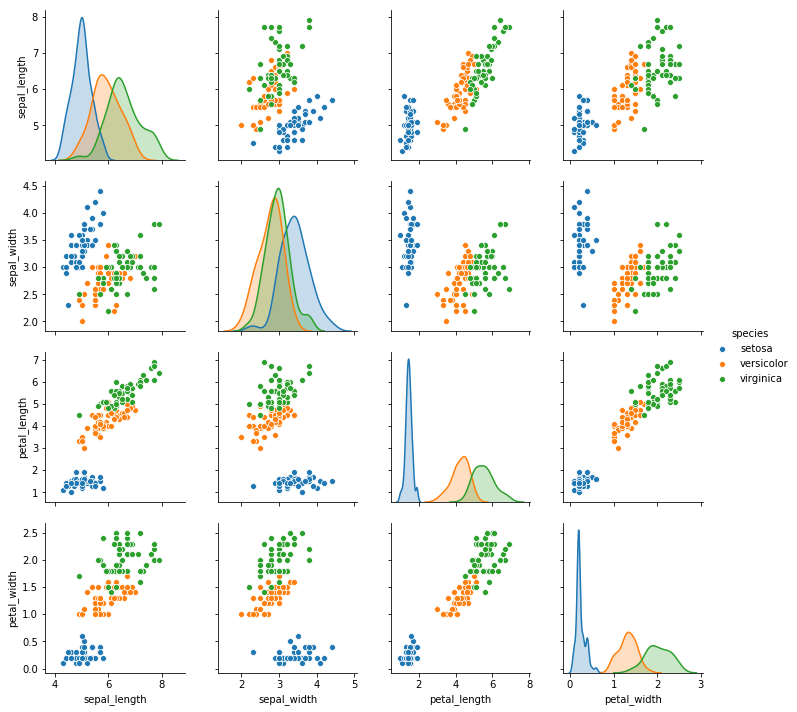

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

iris = sns.load_dataset('iris')

sns.pairplot(iris, hue='species')
plt.show()

Next, we can use corner, which is more suitable to massive sample sizes and struggles under these circumstances:

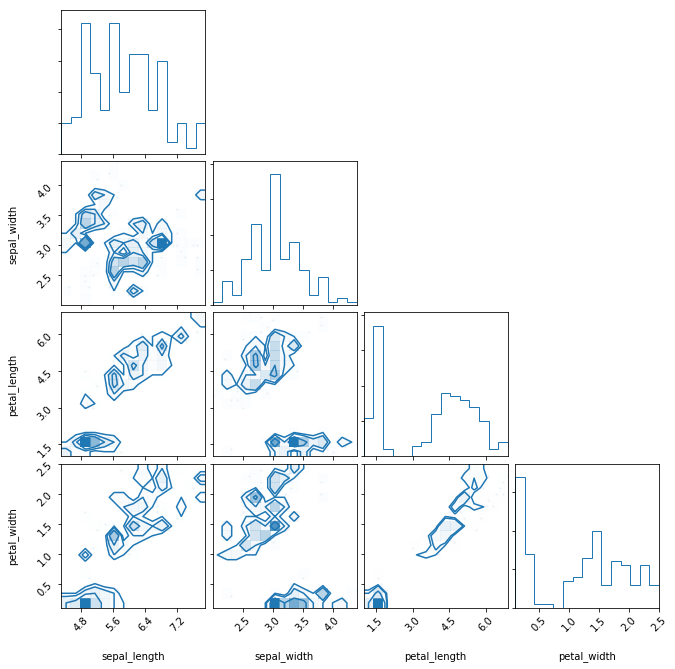

In [207]:
import corner
import matplotlib.pyplot as plt

corner.corner(iris.drop('species', axis=1), bins=15, color='tab:blue')
plt.show()

To see a more illuminating usage of corner, we can make our own dataset of multivariate gaussians:

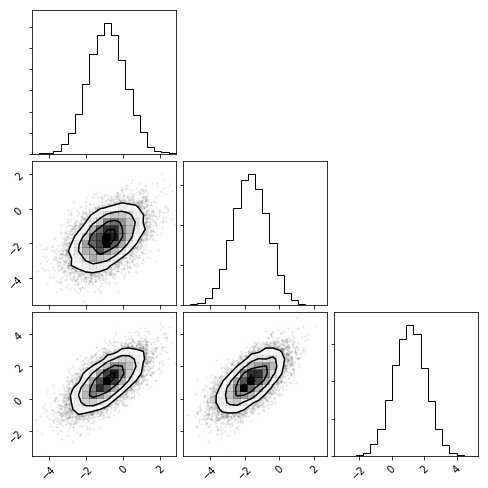

In [210]:
n = 3
means = np.random.uniform(-2, 2, n)
cov = np.random.uniform(0, 1, size=(n,n))
cov = np.maximum(np.mean([cov, cov.T], axis=0), np.identity(n)) 

big_data = np.random.multivariate_normal(mean=means, cov=cov.T, size=10000)
_ = corner.corner(big_data)

We can also make weird looking double gaussians, etc.

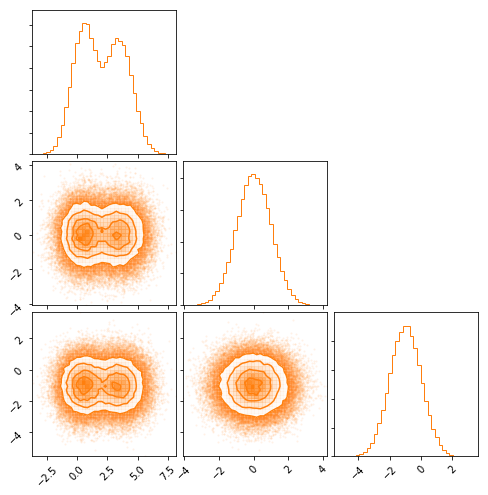

In [211]:
N = 100000
gen = lambda n : np.random.multivariate_normal([0.5, 0, -1], np.identity(3), size=n)
data1,data2,data3 = gen(N),gen(N),gen(N)
data2[:int(N/2),0] += np.random.normal(3, 0.5, size=int(N/2))
data3[int(N/2):,1] += np.random.normal(-3, 0.5, size=int(N/2))

# fig = corner.corner(data1, bins=40, color='tab:blue')
corner.corner(data2, bins=40, color='tab:orange')
# corner.corner(data3, bins=40, color='tab:green', fig=fig)
plt.show()

### fourier transforms and convolutional learning

First we get an mp3 file

In [212]:
!wget http://www.legowelt.org/synthsnipps/MICROKORG5.mp3

--2020-01-29 17:37:37--  http://www.legowelt.org/synthsnipps/MICROKORG5.mp3
Resolving www.legowelt.org (www.legowelt.org)... 93.90.146.104, 2a06:1002::5d5a:9268
Connecting to www.legowelt.org (www.legowelt.org)|93.90.146.104|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1326601 (1.3M) [audio/mpeg]
Saving to: ‘MICROKORG5.mp3’

MICROKORG5.mp3      100%[===================>]   1.26M   348KB/s    in 4.0s    

2020-01-29 17:37:42 (320 KB/s) - ‘MICROKORG5.mp3’ saved [1326601/1326601]



In [0]:
help(ef.datasets.qg_jets.load)

Help on function load in module energyflow.datasets.qg_jets:

load(num_data=100000, generator='pythia', pad=True, with_bc=False, cache_dir='~/.energyflow')
    Loads samples from the dataset (which in total is contained in twenty 
    files). Any file that is needed that has not been cached will be 
    automatically downloaded. Downloading a file causes it to be cached for
    later use. Basic checksums are performed.
    
    **Arguments**
    
    - **num_data** : _int_
        - The number of events to return. A value of `-1` means read in all
        events.
    - **generator** : _str_
        - Specifies which Monte Carlo generator the events should come from.
        Currently, the options are `'pythia'` and `'herwig'`.
    - **pad** : _bool_
        - Whether to pad the events with zeros to make them the same length.
        Note that if set to `False`, the returned `X` array will be an object
        array and not a 3-d array of floats.
    - **with_bc** : _bool_
        - Whe

In [1]:
housing.plot(kind='scatter', x='longitude', y='latitude',
            c='median_house_value', figsize=(10,10),
             cmap='jet', s=housing['population']/100, 
             label='population', alpha=0.35, colorbar=True
            )

import matplotlib.pyplot as plt
plt.gca().set_aspect(1)
plt.show()

NameError: name 'housing' is not defined

In [2]:


n = 3
means = np.random.uniform(-2, 2, n)
cov = np.random.uniform(0, 1, size=(n,n))
cov = np.maximum(np.mean([cov, cov.T], axis=0), np.identity(n)) 

big_data = np.random.multivariate_normal(mean=means, cov=cov.T, size=10000)
_ = corner.corner(big_data)

print(cov)
np.mean([cov, cov.T], axis=0)

cov

import pandas as pd
import seaborn as sns

iris = sns.load_dataset('iris')



sns.pairplot(iris)



import corner
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = None
for i,s in enumerate(iris.species.unique()):
    fig = corner.corner(iris[iris.species == s].drop('species', axis=1), fig=fig, bins=10, color=colors[i], range=list(zip(iris.min().values, iris.max().values))[:-1])
plt.show()

NameError: name 'np' is not defined